Adapted by Rosa Zwart from Jupyter Notebooks found at https://github.com/PPerdomoQ/rare-disease-explainer

# Import Libraries

Package                       Version
----------------------------- ----------
aiosignal                     1.3.1
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asttokens                     2.2.1
attrs                         22.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.2
bleach                        6.0.0
certifi                       2023.5.7
cffi                          1.15.1
charset-normalizer            3.1.0
click                         8.1.3
colorama                      0.4.6
comm                          0.1.3
contourpy                     1.0.7
cycler                        0.11.0
debugpy                       1.6.6
decorator                     5.1.1
deepsnap                      0.2.1
defusedxml                    0.7.1
distlib                       0.3.6
executing                     1.2.0
fastjsonschema                2.16.3
filelock                      3.12.0
fonttools                     4.39.3
fqdn                          1.5.1
frozenlist                    1.3.3
gensim                        4.3.1
grpcio                        1.54.0
idna                          3.4
importlib-metadata            6.6.0
ipykernel                     6.20.2
ipython                       8.13.2
ipython-genutils              0.2.0
ipywidgets                    8.0.6
isoduration                   20.11.0
jedi                          0.18.2
Jinja2                        3.1.2
joblib                        1.2.0
jsonpointer                   2.3
jsonschema                    4.17.3
jupyter                       1.0.0
jupyter_client                8.2.0
jupyter-console               6.6.3
jupyter_core                  5.3.0
jupyter-events                0.6.3
jupyter_server                2.5.0
jupyter_server_terminals      0.4.4
jupyterlab-pygments           0.2.2
jupyterlab-widgets            3.0.7
kiwisolver                    1.4.4
MarkupSafe                    2.1.2
matplotlib                    3.7.1
matplotlib-inline             0.1.6
mistune                       2.0.5
msgpack                       1.0.5
nbclassic                     1.0.0
nbclient                      0.7.4
nbconvert                     7.4.0
nbformat                      5.8.0
nest-asyncio                  1.5.6
networkx                      3.0
notebook                      6.5.4
notebook_shim                 0.2.3
numpy                         1.24.3
packaging                     23.1
pandas                        1.3.5
pandocfilters                 1.5.0
parso                         0.8.3
pickleshare                   0.7.5
Pillow                        9.5.0
pip                           23.1.2
platformdirs                  3.5.0
prometheus-client             0.16.0
prompt-toolkit                3.0.38
protobuf                      4.23.0
psutil                        5.9.1
pure-eval                     0.2.2
pycparser                     2.21
Pygments                      2.15.1
pyparsing                     3.0.9
pyrsistent                    0.19.3
python-dateutil               2.8.2
python-json-logger            2.0.7
pytz                          2023.3
pywin32                       303
pywinpty                      2.0.10
PyYAML                        6.0
pyzmq                         25.0.2
qtconsole                     5.4.3
QtPy                          2.3.1
ray                           2.3.1
requests                      2.30.0
rfc3339-validator             0.1.4
rfc3986-validator             0.1.1
scikit-learn                  1.2.2
scipy                         1.10.1
Send2Trash                    1.8.2
setuptools                    66.0.0
six                           1.16.0
smart-open                    6.3.0
sniffio                       1.3.0
soupsieve                     2.4.1
stack-data                    0.6.2
tabulate                      0.9.0
terminado                     0.17.1
threadpoolctl                 3.1.0
tinycss2                      1.2.1
torch                         1.11.0+cpu
torch-cluster                 1.6.0
torch-geometric               2.0.4
torch-scatter                 2.0.9
torch-sparse                  0.6.13
torch-spline-conv             1.2.2
torchaudio                    0.11.0+cpu
torchvision                   0.12.0+cpu
tornado                       6.2
tqdm                          4.65.0
traitlets                     5.9.0
typing_extensions             4.5.0
tzdata                        2023.3
uri-template                  1.2.0
urllib3                       2.0.2
virtualenv                    20.23.0
wcwidth                       0.2.6
webcolors                     1.13
webencodings                  0.5.1
websocket-client              1.5.1
wheel                         0.38.4
widgetsnbextension            4.0.7
zipp                          3.15.0

In [19]:
import pandas as pd
import numpy as np
import networkx as nx
import copy
import pickle

import edge2vec.transition3 as transitions
import edge2vec.edge2vec3 as edge2vec

from gnn.linkpred_model import LinkPredModel, train, test

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv

from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.graph import Graph

from ray import tune

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch_device)

Using device: cpu


Specify which dataset is used, 1 (original knowledge graph) or 2 (restructured knowledge graph)

In [4]:
dataset_nr = 2  # fill in 1 or 2

if dataset_nr == 1:
    FILE_EDGES = 'prev_kg_edges.csv'
    FILE_NODES = 'prev_kg_nodes.csv'
else:
    FILE_EDGES = 'new_kg_edges.csv'
    FILE_NODES = 'new_kg_nodes.csv'

# Load Data

Load all edges of the knowledge graph.

In [6]:
edges = pd.read_csv(f'output/{FILE_EDGES}', header=0)
edges.head(10)

,id,subject,object,relation_id,relation_label,relation_iri
0,15a20d1b-1d4c-4ef5-8960-0bbcee1b4261,WormBase:WBGene00006787,WormBase:WBGene00003929,RO:0002434,interacts with,http://purl.obolibrary.org/obo/RO_0002434
1,78c75c6d-806d-47b4-930f-4544eaa2c5a5,ZFIN:ZDB-GENE-020129-1,ZP:0004595,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
2,34b96ade-f51a-4680-8c53-c00fbf079968,ENSEMBL:ENSCAFG00000001848,RGD:1310277,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
3,d32fd8ea-e219-45d9-be6d-7adcba8289c0,MGI:101864,MP:0002961,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
4,58c47a12-8477-40a3-9009-a200854f84fe,ENSEMBL:ENSMODG00000018459,WormBase:WBGene00003911,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
5,2ec9e759-e9ea-4e9d-ac75-57a643cfd845,MGI:1277151,HP:0012757,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
6,18ad99b9-19c6-419a-bb5e-d49926575675,FlyBase:FBgn0261563,ENSEMBL:ENSMMUG00000004321,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
7,5990c621-27da-4f75-bc39-55ad604f191f,ENSEMBL:ENSFCAG00000012569,HGNC:11873,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017
8,6bdb9894-3967-441e-aa68-f5a37e900c56,WormBase:WBGene00006062,WBPhenotype:0001316,RO:0003303,causes condition,http://purl.obolibrary.org/obo/RO_0003303
9,ed0f0944-a99c-4508-ba34-59675d615d4c,HGNC:8591,MGI:1339984,RO:HOM0000017,in orthology relationship with,http://purl.obolibrary.org/obo/RO_HOM0000017


Extract the relevant columns and rename these columns.

In [7]:
edges = edges[['subject', 'relation_label', 'object']]
edges.rename(columns={'subject': 'head', 'relation_label': 'relation', 'object': 'tail'}, inplace=True)
edges.head(10)

,head,relation,tail
0,WormBase:WBGene00006787,interacts with,WormBase:WBGene00003929
1,ZFIN:ZDB-GENE-020129-1,causes condition,ZP:0004595
2,ENSEMBL:ENSCAFG00000001848,in orthology relationship with,RGD:1310277
3,MGI:101864,causes condition,MP:0002961
4,ENSEMBL:ENSMODG00000018459,in orthology relationship with,WormBase:WBGene00003911
5,MGI:1277151,causes condition,HP:0012757
6,FlyBase:FBgn0261563,in orthology relationship with,ENSEMBL:ENSMMUG00000004321
7,ENSEMBL:ENSFCAG00000012569,in orthology relationship with,HGNC:11873
8,WormBase:WBGene00006062,causes condition,WBPhenotype:0001316
9,HGNC:8591,in orthology relationship with,MGI:1339984


In [8]:
print(f'There are {edges.shape[0]} edges')

There are 85992 edges


Load all nodes of the knowledge graph.

In [9]:
nodes = pd.read_csv(f'output/{FILE_NODES}', header=0)
nodes['index_id'] = nodes.index
nodes.head(10)

,id,label,iri,semantic,index_id
0,MP:0004187,cardia bifida,http://purl.obolibrary.org/obo/MP_0004187,phenotype,0
1,ZP:0100138,muscle tendon junction myotome increased amoun...,http://purl.obolibrary.org/obo/ZP_0100138,phenotype,1
2,MGI:1346525,Sgcd,http://www.informatics.jax.org/accession/MGI:1...,gene,2
3,OMIM:300377.0044,"DMD, LYS770TER",http://omim.org/entry/300377.0044,variant,3
4,ZP:0002210,posterior lateral line neuromast primordium mi...,http://purl.obolibrary.org/obo/ZP_0002210,phenotype,4
5,MP:0020335,abnormal dentate gyrus neuron dendrite morphology,http://purl.obolibrary.org/obo/MP_0020335,phenotype,5
6,HP:0000316,Hypertelorism,http://purl.obolibrary.org/obo/HP_0000316,phenotype,6
7,ZP:0004032,"margin constricted, abnormal",http://purl.obolibrary.org/obo/ZP_0004032,phenotype,7
8,ZP:0003164,"atrium decreased size, abnormal",http://purl.obolibrary.org/obo/ZP_0003164,phenotype,8
9,MP:0003331,increased hepatocellular carcinoma incidence,http://purl.obolibrary.org/obo/MP_0003331,phenotype,9


In [10]:
print(f'There are {nodes.shape[0]} nodes')

There are 10275 nodes


Extract the relevant columns.

In [11]:
nodes = nodes[['index_id', 'id', 'semantic', 'label']]
nodes.head(10)

,index_id,id,semantic,label
0,0,MP:0004187,phenotype,cardia bifida
1,1,ZP:0100138,phenotype,muscle tendon junction myotome increased amoun...
2,2,MGI:1346525,gene,Sgcd
3,3,OMIM:300377.0044,variant,"DMD, LYS770TER"
4,4,ZP:0002210,phenotype,posterior lateral line neuromast primordium mi...
5,5,MP:0020335,phenotype,abnormal dentate gyrus neuron dendrite morphology
6,6,HP:0000316,phenotype,Hypertelorism
7,7,ZP:0004032,phenotype,"margin constricted, abnormal"
8,8,ZP:0003164,phenotype,"atrium decreased size, abnormal"
9,9,MP:0003331,phenotype,increased hepatocellular carcinoma incidence


Convert categorical to numerical values for the semantic groups.

In [12]:
nodes['semantic'] = nodes['semantic'].astype('category')
nodes['semantic_id'] = nodes['semantic'].cat.codes
nodes.head(10)

,index_id,id,semantic,label,semantic_id
0,0,MP:0004187,phenotype,cardia bifida,9
1,1,ZP:0100138,phenotype,muscle tendon junction myotome increased amoun...,9
2,2,MGI:1346525,gene,Sgcd,5
3,3,OMIM:300377.0044,variant,"DMD, LYS770TER",11
4,4,ZP:0002210,phenotype,posterior lateral line neuromast primordium mi...,9
5,5,MP:0020335,phenotype,abnormal dentate gyrus neuron dendrite morphology,9
6,6,HP:0000316,phenotype,Hypertelorism,9
7,7,ZP:0004032,phenotype,"margin constricted, abnormal",9
8,8,ZP:0003164,phenotype,"atrium decreased size, abnormal",9
9,9,MP:0003331,phenotype,increased hepatocellular carcinoma incidence,9


In [13]:
nodes.to_csv(f'output/indexed_nodes_{dataset_nr}.csv', index=False)

The dictionary below can be used as mapping between generated semantic ID and semantic group label.

In [14]:
node_semantic_dict = dict(enumerate(nodes['semantic'].cat.categories))
node_semantic_dict

{0: 'biological artifact',
 1: 'biological process',
 2: 'cellular component',
 3: 'disease',
 4: 'drug',
 5: 'gene',
 6: 'gene product',
 7: 'genotype',
 8: 'molecular function',
 9: 'phenotype',
 10: 'taxon',
 11: 'variant'}

Merge nodes and edges in order to join semantic classes of nodes with heads and tails of the edges.

In [15]:
kg_df = pd.merge(edges, nodes,
                 left_on='head', right_on='id',
                 how='inner')   # TODO: inner changed left
kg_df = kg_df[['head', 'label', 'semantic_id', 'index_id', 'relation', 'tail']]
kg_df.rename(columns={'label': 'label_head', 'semantic_id': 'class_head', 'index_id': 'index_head'}, inplace=True)
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050
5,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001171
6,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001425
7,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0000781
8,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSPTRG00000021480
9,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015556


In [16]:
kg_df = pd.merge(kg_df, nodes,
                 left_on='tail', right_on='id',
                 how='left')
kg_df = kg_df[['head', 'label_head', 'class_head', 'index_head', 'relation', 'tail', 'label', 'semantic_id', 'index_id']]
kg_df.rename(columns={'label': 'label_tail', 'semantic_id': 'class_tail', 'index_id': 'index_tail'}, inplace=True)
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929,pat-2,5,1542
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789,unc-54,5,6544
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555,LAMC1,5,9268
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3,lamc1,5,5387
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050,ENSEMBL:ENSOANG00000001050,5,2204
5,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001171,shortened life span,9,5475
6,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001425,receptor mediated endocytosis defective,9,3057
7,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0000781,body wall muscle thin filament variant,9,7821
8,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSPTRG00000021480,ENSEMBL:ENSPTRG00000021480,5,6347
9,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015556,LAMC2,5,769


The indices in the `index_id` column can be found as the actual indices of the row. So, this column can be removed as it was only needed for merging purposes.

In [17]:
nodes.drop('index_id', axis=1, inplace=True)
nodes.head(10)

,id,semantic,label,semantic_id
0,MP:0004187,phenotype,cardia bifida,9
1,ZP:0100138,phenotype,muscle tendon junction myotome increased amoun...,9
2,MGI:1346525,gene,Sgcd,5
3,OMIM:300377.0044,variant,"DMD, LYS770TER",11
4,ZP:0002210,phenotype,posterior lateral line neuromast primordium mi...,9
5,MP:0020335,phenotype,abnormal dentate gyrus neuron dendrite morphology,9
6,HP:0000316,phenotype,Hypertelorism,9
7,ZP:0004032,phenotype,"margin constricted, abnormal",9
8,ZP:0003164,phenotype,"atrium decreased size, abnormal",9
9,MP:0003331,phenotype,increased hepatocellular carcinoma incidence,9


In [18]:
kg_df.head(15)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929,pat-2,5,1542
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789,unc-54,5,6544
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555,LAMC1,5,9268
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3,lamc1,5,5387
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050,ENSEMBL:ENSOANG00000001050,5,2204
5,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001171,shortened life span,9,5475
6,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001425,receptor mediated endocytosis defective,9,3057
7,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0000781,body wall muscle thin filament variant,9,7821
8,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSPTRG00000021480,ENSEMBL:ENSPTRG00000021480,5,6347
9,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015556,LAMC2,5,769


# Preparation E2V Data

Encode string values of relation labels as numeric values.

In [20]:
kg_df['type'], relation_labels = pd.factorize(kg_df['relation'])
kg_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929,pat-2,5,1542,0
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789,unc-54,5,6544,0
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555,LAMC1,5,9268,1
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3,lamc1,5,5387,1
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050,ENSEMBL:ENSOANG00000001050,5,2204,1
5,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001171,shortened life span,9,5475,2
6,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001425,receptor mediated endocytosis defective,9,3057,2
7,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0000781,body wall muscle thin filament variant,9,7821,2
8,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSPTRG00000021480,ENSEMBL:ENSPTRG00000021480,5,6347,1
9,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015556,LAMC2,5,769,1


Index list can be used later for converting back to the label of the relation.

In [21]:
relation_labels

Index(['interacts with', 'in orthology relationship with', 'causes condition',
       'involved in', 'found in', 'is part of', 'enables', 'colocalizes with',
       'has role in modeling', 'contributes to condition', 'expresses gene',
       'has affected feature', 'is of', 'likely causes condition',
       'is variant in', 'is allele of', 'is substance that treats', 'targets',
       'associated with phenotype', 'is product of', 'has genotype'],
      dtype='object')

Extract the relevant columns for applying the Edge2Vec method.

In [22]:
edge2vec_df = kg_df.copy()
#edge2vec_df = kg_df.drop(['head', 'relation', 'tail'], axis=1)
edge2vec_df['index_head'] = edge2vec_df['index_head'].apply(str)
edge2vec_df['index_tail'] = edge2vec_df['index_tail'].apply(str)
edge2vec_df.head(10)

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929,pat-2,5,1542,0
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789,unc-54,5,6544,0
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555,LAMC1,5,9268,1
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3,lamc1,5,5387,1
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050,ENSEMBL:ENSOANG00000001050,5,2204,1
5,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001171,shortened life span,9,5475,2
6,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0001425,receptor mediated endocytosis defective,9,3057,2
7,WormBase:WBGene00006787,unc-52,5,304,causes condition,WBPhenotype:0000781,body wall muscle thin filament variant,9,7821,2
8,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSPTRG00000021480,ENSEMBL:ENSPTRG00000021480,5,6347,1
9,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015556,LAMC2,5,769,1


In [23]:
print(f'There are {edge2vec_df.shape[0]} edges')

There are 85992 edges


In [21]:
edge2vec_df.to_csv(f'output/indexed_edges_{dataset_nr}.csv', index=False)

Initialize edge list with keys 'type' and 'weight'. The 'weight' of each edge is initialized to 1.0. 

In [477]:
G = nx.from_pandas_edgelist(edge2vec_df, 'index_head', 'index_tail', 'type', create_using=nx.DiGraph(), edge_key= (('type', int),('id', int)))
G = G.to_undirected()   # for the E2V implementation, use indirected graph
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1.0

In [478]:
for node in G.nodes(data=True):
    print('First node in graph:', node)
    break

for edge in G.edges(data=True):
    print('First edge in graph:', edge)
    break

print('Total number of edges is {}'.format(G.number_of_edges()))
print('Total number of nodes is {}'.format(G.number_of_nodes()))

First node in graph: ('304', {})
First edge in graph: ('304', '1542', {'type': 0, 'weight': 1.0})
Total number of edges is 55032
Total number of nodes is 10275


# Obtain Node Embeddings with E2V

In [479]:
type_size = len(set(edge2vec_df['type']))
print(f'There are {type_size} edge types')

There are 21 edge types


Define parameters and generate edge type transition matrix using Edge2Vec EM approach

In [480]:
# Use parameter values obtained with hyperparameter optimization
if dataset_nr == 1:
    epoch = 10  # number of epochs
    num_walks = 4   # number of walks per node
    walk_length = 7 # length of each walk
    p = 0.75
    q = 0.75
else:
    epoch = 5  # number of epochs
    num_walks = 6   # number of walks per node
    walk_length = 7 # length of each walk
    p = 0.75
    q = 1

directed = True
e_step = 3

print('Initializing transition matrix...')
M = transitions.initialize_edge_type_matrix(type_size)

print('Updating transition matrix...')
for i in range(epoch):
    walks = transitions.simulate_walks_1(G, num_walks, walk_length, M, directed, p, q) # M step
    print(f'{i}th iteration of updating matrix')
    M = transitions.update_trans_matrix(walks, type_size, e_step) # E step

print("Finished generating values for transition matrix!")

Initializing transition matrix...
Updating transition matrix...
Walk iteration:
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
0th iteration of updating matrix


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Walk iteration:
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
1th iteration of updating matrix
Walk iteration:
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
2th iteration of updating matrix
Walk iteration:
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
3th iteration of updating matrix
Walk iteration:
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6
4th iteration of updating matrix
Finished generating values for transition matrix!


In [481]:
print('Overview of resulting edge type transition matrix (float values have been truncated to fit the view!):')
print('\n'.join(['\t'.join([str(cell)[:5] for cell in row]) for row in M]))

Overview of resulting edge type transition matrix (float values have been truncated to fit the view!):
0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5
1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	0.5	1.0	1.0	1.0	1

In [482]:
np.save(f'output/transitionmatrix_{dataset_nr}.npy', M)

Generate walks constrained by final edge type transition matrix

In [483]:
print('Generate walks constrained by edge type transition matrix...')
walks = edge2vec.simulate_walks_2(G, num_walks, walk_length, M, p, q)

Generate walks constrained by edge type transition matrix...
Walk iteration:
1 / 6


2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


Generate node embeddings using Word2Vec (skip-gram model) with as input the generated walks

In [484]:
if dataset_nr == 1:
    dim = 64    # desired dimension of the node embedding
    epochs = 10
else:
    dim = 64
    epochs = 10

window_size = walk_length - 1   # maximum distance between predicted and context node
workers = 8 # threads used

w2v_model = edge2vec.Word2Vec(walks, vector_size=dim, window=window_size, min_count=0, sg=1, workers=workers, epochs=epochs)

Save the node embeddings

In [485]:
word_vectors = w2v_model.wv
word_vectors.save(f'output/w2v_{dataset_nr}.dvectors')

In [486]:
e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(w2v_model.wv.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(w2v_model.wv[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')

The embeddings of each node in the graph

In [487]:
e2v_embedding

,Node,Embedding
0,0,"[0.19341904, -0.41745484, -0.12364431, 0.16638..."
1,1,"[0.579751, -0.5968621, 0.4189877, -0.19671474,..."
2,2,"[-0.09172324, -0.17067072, 0.024856096, 0.1898..."
3,3,"[0.29931498, -0.1667258, 0.5257502, 0.5293044,..."
4,4,"[0.117773786, -0.21425456, -0.22285198, 0.0990..."
...,...,...
10270,10270,"[0.37877187, -0.017005594, 0.3257357, 0.199831..."
10271,10271,"[0.2916055, -0.45973212, -0.015776878, -0.6851..."
10272,10272,"[-0.11948804, -0.29105687, 0.60765344, -0.0433..."
10273,10273,"[0.07694234, -0.4507158, 0.32198328, 0.1689011..."


# Link Prediction

Creating a graph including the node embeddings as features of each node.

In [488]:
embedded_node_G = nx.DiGraph() # TODO: changed from Graph

for ind, node in e2v_embedding.iterrows(): 
  embedded_node_G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
  embedded_node_G.add_edge(int(edge['index_head']), int(edge['index_tail']))
    
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1934, -0.4175, -0.1236,  0.1664,  0.3628, -0.6092,  0.1288, -0.3537,
        -0.5665, -0.0265,  0.5941, -0.0500, -0.4676, -0.5701,  0.5306,  0.6816,
        -0.5057, -0.4247,  0.2428,  0.4946,  0.6948,  0.8011,  0.1991, -0.4635,
        -0.1337,  0.1609, -0.5184, -0.2800,  0.5739, -0.2524, -0.0543, -0.4784,
         0.2787,  0.0488, -0.2610,  0.6490,  0.3472, -0.1858,  0.6145,  0.1745,
         0.2946,  0.2218,  0.3575,  0.0877, -0.5840,  0.1926,  0.6603, -0.7829,
         0.0733, -0.4376,  0.1557,  0.0560,  0.3634, -0.1627,  0.1379, -0.1113,
         0.5885, -0.3621, -0.1135,  0.4481,  0.0223,  0.0096, -0.1575,  0.6008])})
(2, 7693, {})
Number of edges is 85878
Number of nodes is 10275


## Generate graph datasets for training, validation and testing

Transductive link prediction split (https://zqfang.github.io/2021-08-12-graph-linkpredict/):
- Train/validation/test sets are on the same graph
- The dataset consists of one graph
- The entire graph can be observed in all dataset splits
- The labels of the edges are split

In [489]:
dataset = GraphDataset(
    embedded_node_G,
    task='link_pred',
    edge_train_mode='all'
)

datasets = {}
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

print(f'Input dimension (embedding dimension): {input_dim} \n Number of edge classes (link or no link): {num_classes}')   

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Input dimension (embedding dimension): 64 
 Number of edge classes (link or no link): 2


Dataloaders allow to feed data into the model by batch.

In [490]:
dataloaders = {split: DataLoader(ds, collate_fn=Batch.collate([]), batch_size=1, shuffle=(split=='train')) for split, ds in datasets.items()}

## Train GNN

### Predefined Arguments

Train GNN with predefined arguments

In [491]:
if dataset_nr == 1:
    args = {
        "device" : torch_device,   # insert torch_device, or 'cpu' 
        "hidden_dim" : 64,
        'output_dim': 128,
        "epochs" : 150, 
        'lr': 0.03834732671672826, 
        'aggr': 'mean', 
        'layers': 2, 
        'dropout': 0
    }
else:
    args = {
        "device" : torch_device,   # insert torch_device, or 'cpu' 
        "hidden_dim" : 256,
        'output_dim': 64,
        "epochs" : 100, 
        'lr': 0.013477408995651594, 
        'aggr': 'mean', 
        'layers': 2, 
        'dropout': 0.2
    }

print(args)

model = LinkPredModel(input_dim, args["hidden_dim"], args['output_dim'], args['layers'], args['aggr'], args['dropout'], args["device"]).to(args["device"])
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)

{'device': device(type='cpu'), 'hidden_dim': 256, 'output_dim': 64, 'epochs': 100, 'lr': 0.013477408995651594, 'aggr': 'mean', 'layers': 2, 'dropout': 0.2}


In [493]:
best_model, best_x, performance = train(model, dataloaders, optimizer, args)

best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)

print('Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(best_train_roc, best_val_roc, best_test_roc))

Start Train Function


Epoch: 001, Train: 0.9537, Val: 0.9399, Test: 0.9397, Loss: 2.23933


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 002, Train: 0.9513, Val: 0.9384, Test: 0.9388, Loss: 2.13876


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 003, Train: 0.9479, Val: 0.9341, Test: 0.9346, Loss: 2.03719


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 004, Train: 0.9454, Val: 0.9301, Test: 0.9306, Loss: 1.98919


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 005, Train: 0.9448, Val: 0.9288, Test: 0.9293, Loss: 1.93418


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 006, Train: 0.9457, Val: 0.9295, Test: 0.9301, Loss: 1.90617


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 007, Train: 0.9461, Val: 0.9308, Test: 0.9315, Loss: 1.84822


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 008, Train: 0.9469, Val: 0.9312, Test: 0.9319, Loss: 1.82890


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 009, Train: 0.9461, Val: 0.9304, Test: 0.9309, Loss: 1.79257


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 010, Train: 0.9437, Val: 0.9288, Test: 0.9290, Loss: 1.76228


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 011, Train: 0.9427, Val: 0.9273, Test: 0.9270, Loss: 1.73164


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 012, Train: 0.9414, Val: 0.9266, Test: 0.9259, Loss: 1.67365


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 013, Train: 0.9423, Val: 0.9275, Test: 0.9265, Loss: 1.62744


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 014, Train: 0.9445, Val: 0.9301, Test: 0.9288, Loss: 1.64339


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 015, Train: 0.9475, Val: 0.9338, Test: 0.9323, Loss: 1.59471


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 016, Train: 0.9514, Val: 0.9379, Test: 0.9363, Loss: 1.56754


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 017, Train: 0.9546, Val: 0.9416, Test: 0.9397, Loss: 1.54243


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 018, Train: 0.9575, Val: 0.9446, Test: 0.9426, Loss: 1.52135


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 019, Train: 0.9604, Val: 0.9472, Test: 0.9451, Loss: 1.48171


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 020, Train: 0.9620, Val: 0.9493, Test: 0.9470, Loss: 1.45941


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 021, Train: 0.9634, Val: 0.9511, Test: 0.9488, Loss: 1.40908


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 022, Train: 0.9652, Val: 0.9530, Test: 0.9506, Loss: 1.39867


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 023, Train: 0.9670, Val: 0.9550, Test: 0.9527, Loss: 1.34982


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 024, Train: 0.9690, Val: 0.9572, Test: 0.9549, Loss: 1.35005


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 025, Train: 0.9708, Val: 0.9592, Test: 0.9571, Loss: 1.32416


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 026, Train: 0.9731, Val: 0.9612, Test: 0.9592, Loss: 1.31327


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 027, Train: 0.9742, Val: 0.9629, Test: 0.9610, Loss: 1.29058


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 028, Train: 0.9759, Val: 0.9643, Test: 0.9626, Loss: 1.25160


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 029, Train: 0.9762, Val: 0.9655, Test: 0.9639, Loss: 1.25620


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 030, Train: 0.9769, Val: 0.9665, Test: 0.9650, Loss: 1.22791


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 031, Train: 0.9780, Val: 0.9673, Test: 0.9659, Loss: 1.20977


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.9784, Val: 0.9680, Test: 0.9666, Loss: 1.18147


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 033, Train: 0.9790, Val: 0.9687, Test: 0.9673, Loss: 1.17644


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 034, Train: 0.9794, Val: 0.9693, Test: 0.9679, Loss: 1.14924


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.9801, Val: 0.9698, Test: 0.9684, Loss: 1.13104


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.9804, Val: 0.9702, Test: 0.9688, Loss: 1.12083


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 037, Train: 0.9803, Val: 0.9706, Test: 0.9693, Loss: 1.09043


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 038, Train: 0.9802, Val: 0.9710, Test: 0.9697, Loss: 1.08351


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 039, Train: 0.9808, Val: 0.9713, Test: 0.9700, Loss: 1.06704


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 040, Train: 0.9807, Val: 0.9715, Test: 0.9703, Loss: 1.04431


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 041, Train: 0.9807, Val: 0.9718, Test: 0.9705, Loss: 1.03403


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 042, Train: 0.9806, Val: 0.9719, Test: 0.9706, Loss: 1.01692


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 043, Train: 0.9808, Val: 0.9720, Test: 0.9707, Loss: 0.99739


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 044, Train: 0.9808, Val: 0.9721, Test: 0.9708, Loss: 0.99812


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 045, Train: 0.9807, Val: 0.9722, Test: 0.9710, Loss: 0.98026


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 046, Train: 0.9810, Val: 0.9723, Test: 0.9711, Loss: 0.96550


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 047, Train: 0.9804, Val: 0.9724, Test: 0.9712, Loss: 0.95099


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 048, Train: 0.9804, Val: 0.9724, Test: 0.9712, Loss: 0.93684


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 049, Train: 0.9808, Val: 0.9724, Test: 0.9713, Loss: 0.93359


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 050, Train: 0.9801, Val: 0.9725, Test: 0.9713, Loss: 0.91995


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 051, Train: 0.9803, Val: 0.9725, Test: 0.9714, Loss: 0.90065


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 052, Train: 0.9802, Val: 0.9725, Test: 0.9714, Loss: 0.89663


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 053, Train: 0.9806, Val: 0.9726, Test: 0.9714, Loss: 0.87255


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 054, Train: 0.9802, Val: 0.9726, Test: 0.9714, Loss: 0.86654


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 055, Train: 0.9804, Val: 0.9726, Test: 0.9715, Loss: 0.85472


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 056, Train: 0.9798, Val: 0.9725, Test: 0.9714, Loss: 0.85070


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 057, Train: 0.9803, Val: 0.9725, Test: 0.9714, Loss: 0.83582


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 058, Train: 0.9796, Val: 0.9725, Test: 0.9714, Loss: 0.82736


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 059, Train: 0.9795, Val: 0.9725, Test: 0.9714, Loss: 0.82382


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 060, Train: 0.9804, Val: 0.9725, Test: 0.9714, Loss: 0.82002


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 061, Train: 0.9796, Val: 0.9724, Test: 0.9714, Loss: 0.79859


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 062, Train: 0.9796, Val: 0.9724, Test: 0.9714, Loss: 0.79869


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 063, Train: 0.9792, Val: 0.9725, Test: 0.9714, Loss: 0.78096


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 064, Train: 0.9794, Val: 0.9725, Test: 0.9715, Loss: 0.77450


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 065, Train: 0.9794, Val: 0.9725, Test: 0.9715, Loss: 0.76701


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 066, Train: 0.9799, Val: 0.9725, Test: 0.9715, Loss: 0.76526


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 067, Train: 0.9796, Val: 0.9726, Test: 0.9715, Loss: 0.75074


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.9791, Val: 0.9725, Test: 0.9715, Loss: 0.74030


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 069, Train: 0.9795, Val: 0.9725, Test: 0.9716, Loss: 0.73867


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.9791, Val: 0.9726, Test: 0.9716, Loss: 0.72049


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 071, Train: 0.9792, Val: 0.9726, Test: 0.9717, Loss: 0.71852


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.9794, Val: 0.9726, Test: 0.9717, Loss: 0.71554


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 073, Train: 0.9797, Val: 0.9727, Test: 0.9718, Loss: 0.71561


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.9788, Val: 0.9727, Test: 0.9718, Loss: 0.70640


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 075, Train: 0.9796, Val: 0.9728, Test: 0.9719, Loss: 0.69734


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.9794, Val: 0.9728, Test: 0.9720, Loss: 0.70431


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 077, Train: 0.9802, Val: 0.9729, Test: 0.9721, Loss: 0.67936


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.9795, Val: 0.9730, Test: 0.9722, Loss: 0.68097


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 079, Train: 0.9800, Val: 0.9730, Test: 0.9723, Loss: 0.66757


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 080, Train: 0.9798, Val: 0.9731, Test: 0.9725, Loss: 0.65895


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 081, Train: 0.9800, Val: 0.9732, Test: 0.9726, Loss: 0.67912


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 082, Train: 0.9799, Val: 0.9733, Test: 0.9728, Loss: 0.65728


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 083, Train: 0.9802, Val: 0.9733, Test: 0.9729, Loss: 0.65577


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 084, Train: 0.9807, Val: 0.9734, Test: 0.9730, Loss: 0.63891


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 085, Train: 0.9798, Val: 0.9734, Test: 0.9731, Loss: 0.64696


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 086, Train: 0.9803, Val: 0.9735, Test: 0.9731, Loss: 0.63358


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 087, Train: 0.9803, Val: 0.9735, Test: 0.9732, Loss: 0.63875


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 088, Train: 0.9802, Val: 0.9736, Test: 0.9733, Loss: 0.63611


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.9802, Val: 0.9737, Test: 0.9734, Loss: 0.60670


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 090, Train: 0.9802, Val: 0.9738, Test: 0.9734, Loss: 0.62193


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 091, Train: 0.9799, Val: 0.9738, Test: 0.9735, Loss: 0.60591


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 092, Train: 0.9810, Val: 0.9739, Test: 0.9736, Loss: 0.62141


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 093, Train: 0.9806, Val: 0.9740, Test: 0.9737, Loss: 0.60446


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 094, Train: 0.9810, Val: 0.9741, Test: 0.9738, Loss: 0.61003


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 095, Train: 0.9807, Val: 0.9742, Test: 0.9739, Loss: 0.59956


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 096, Train: 0.9809, Val: 0.9743, Test: 0.9740, Loss: 0.58718


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 097, Train: 0.9808, Val: 0.9743, Test: 0.9741, Loss: 0.58577


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 098, Train: 0.9815, Val: 0.9744, Test: 0.9742, Loss: 0.59015


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 099, Train: 0.9816, Val: 0.9745, Test: 0.9744, Loss: 0.58300


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Train: 0.9815, Val: 0.9745, Test: 0.9744


Save the model and parameters

In [494]:
torch.save(best_model.state_dict(), f'output/best_model_{dataset_nr}.pth')
with open(f'output/best_model_{dataset_nr}_args.pkl', 'wb') as f:
    pickle.dump(args, f)

### Visualize Trained GNN Model Accuracy

Plot AUC and loss throughout epochs

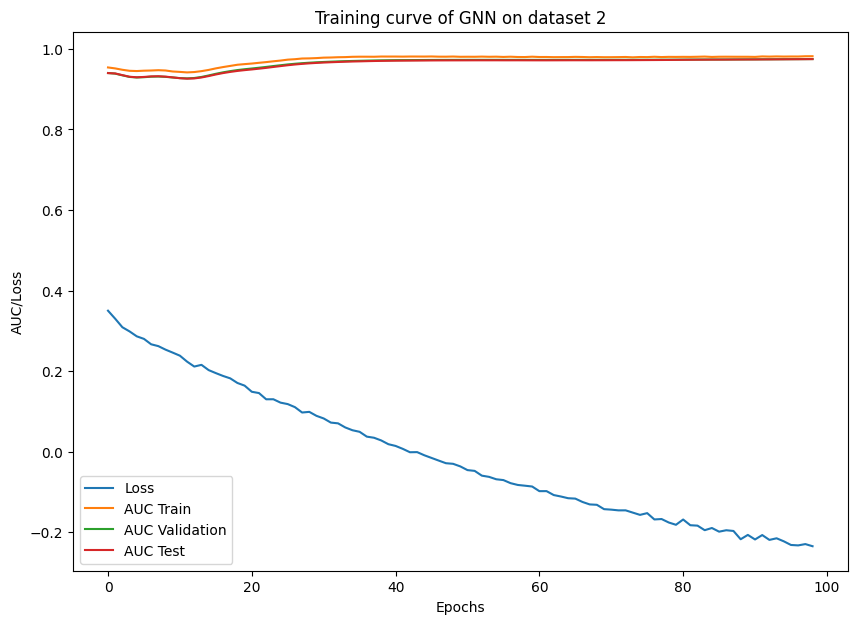

In [495]:
plt.figure(figsize= (10,7))
plt.plot(np.log10(performance[0]), label = 'Loss')
plt.plot(performance[1], label = 'AUC Train')
plt.plot(performance[2], label = 'AUC Validation')
plt.plot(performance[3], label = 'AUC Test')
plt.legend()
plt.ylabel('AUC/Loss')
plt.xlabel('Epochs')
plt.title(f'Training curve of GNN on dataset {dataset_nr}')
plt.show()

Plot ROC curve using test set
- High TPR and lower FPR indicates that the proportion of correctly classified samples (true positives) is greater than the proportion of incorrectly classified samples (false positives)

0.9743823314880399


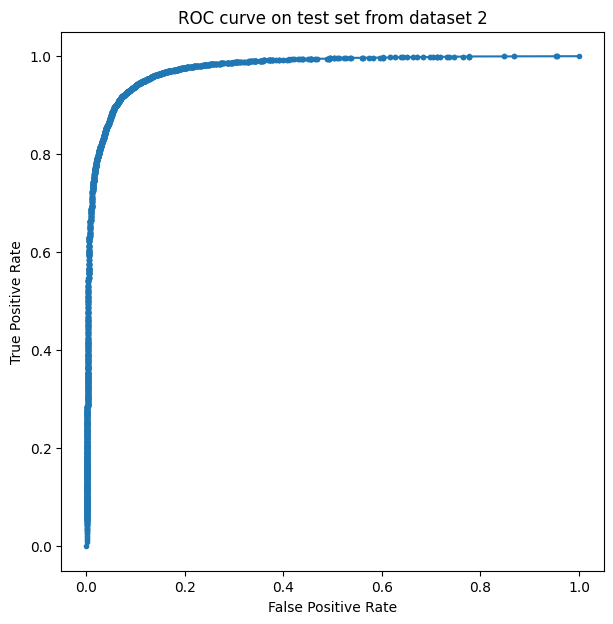

In [496]:
for batch in dataloaders['test']:
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    batch.to(args["device"])
    pred, x = best_model(feat, edge_index, edge_label_index, training = False)
    pred = torch.sigmoid(pred)
    score = roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    print(score)
    
fpr, tpr, thresholds = roc_curve(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')   # 1 - specificity
plt.ylabel('True Positive Rate')    # sensitivity
plt.title(f'ROC curve on test set from dataset {dataset_nr}')
plt.show()

Calculate F1-score using test set

Elements of the F1-score:
- Precision represents the proportion of correctly classifying samples as positive (high precision: classifying a sample as positive has a high probability to be correct)
- Recall represents the proportion of finding all positives (high recall: all positive samples have been classified as being positive)

Maximizing both elements in order to yield a model that identifies all positive samples and only identifies these samples as positives.

For the F1-score, the average of precision and recall is calculated, using the harmonic mean method (equal importance):
- High F1-score indicates that precision and recall are both high
- Medium F1-score indicates that one of the elements is high and the other low
- Low F1-score indicates that precision and recall are both low

In [497]:
def test_f1(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += f1_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy(), score

true_label, pred_label, best_test_f1 = test_f1(best_model, dataloaders['test'], args, 0.75)
print(f'F1-Score in the test set of dataset {dataset_nr}:', best_test_f1)
print(classification_report(true_label, pred_label))

F1-Score in the test set of dataset 2: 0.9023572664359862
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      8589
           1       0.84      0.97      0.90      8589

    accuracy                           0.89     17178
   macro avg       0.90      0.89      0.89     17178
weighted avg       0.90      0.89      0.89     17178



In [498]:
def test_cm(model, dataloader, args, threshold):
    model.eval()
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score = confusion_matrix(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    return score

table = test_cm(best_model, dataloaders['train'], args, 0.8)
print(table)

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


[[59679  9023]
 [ 1587 67115]]


# Hyperparameter Optimization of Node Embedding and GNN Training

The routine including node embedding and GNN training that needs to be optimized is contained in `hyperparam_opt.py`.

# GNN Predictions

Load the Edge2Vec embedding

In [5]:
node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')

e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')
e2v_embedding

,Node,Embedding
0,0,"[0.4429384, -0.64671946, -0.045503706, 0.04694..."
1,1,"[0.7495496, -0.5790302, 0.16192597, 0.03131027..."
2,2,"[-0.21050918, -0.28908953, 0.118277326, -0.162..."
3,3,"[0.2527442, -0.2967686, 0.29164207, 0.8072669,..."
4,4,"[0.41442072, 0.06997513, 0.4540072, -0.0370618..."
...,...,...
10270,10270,"[0.21862394, 0.11319974, 0.31551972, 0.1497048..."
10271,10271,"[0.8747792, -0.7461259, 0.22221777, -0.0425329..."
10272,10272,"[0.5863251, -0.8054981, 0.27565393, 0.516578, ..."
10273,10273,"[0.6474387, -0.38251266, 0.43746328, 0.3413055..."


Initialize a graph with nodes and their embedding features.

In [33]:
G = nx.DiGraph() # TODO: changed from Graph
for ind, node in e2v_embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']))
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.4429, -0.6467, -0.0455,  0.0469,  0.3007, -0.4822,  0.2423,  0.0707,
        -0.5349,  0.4175,  0.7552,  0.0628, -0.3813, -0.3389,  0.5671,  0.4919,
         0.0854,  0.0053, -0.2314,  0.8349,  0.5443,  0.7359, -0.1399, -0.2049,
        -0.1793,  0.0314, -0.7152,  0.1764,  0.3586, -0.4770,  0.0838, -0.3013,
         0.1751, -0.7785, -0.1280,  0.4082,  0.5959,  0.4058,  0.5182,  0.5561,
         0.3995, -0.1704,  0.3317, -0.1183, -0.1047,  0.2789,  0.3293, -0.1368,
         0.1259,  0.1704,  0.7724,  0.4460,  0.6070, -0.3315,  0.5776,  0.4367,
         0.2875, -0.7309,  0.2535,  0.5972,  0.4410, -0.4248, -0.3355,  0.3258])})
(2, 7693, {})
Number of edges is 85878
Number of nodes is 10275


In [34]:
DeepG = Graph(G)
print(DeepG.edge_index.shape)

torch.Size([2, 85878])


Load arguments and parameters of trained GNN model.

In [35]:
with open(f'output/best_model_{dataset_nr}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(e2v_embedding['Embedding'][0]), loaded_args['hidden_dim'], loaded_args['output_dim'], loaded_args['layers'], loaded_args['aggr'], loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}.pth'))

<All keys matched successfully>

Get output of best model given the graph

In [36]:
_, best_x = best_model(DeepG.node_feature, DeepG.edge_index, DeepG.edge_label_index, training = False)
print(best_x.shape)

torch.Size([10275, 64])


In [37]:
nodes

,id,semantic,label,semantic_id
0,MP:0004187,phenotype,cardia bifida,9
1,ZP:0100138,phenotype,muscle tendon junction myotome increased amoun...,9
2,MGI:1346525,gene,Sgcd,5
3,OMIM:300377.0044,variant,"DMD, LYS770TER",11
4,ZP:0002210,phenotype,posterior lateral line neuromast primordium mi...,9
...,...,...,...,...
10270,ZP:0014934,phenotype,atrioventricular valve development process qua...,9
10271,ENSEMBL:ENSCAFG00000011207,gene,ENSEMBL:ENSCAFG00000011207,5
10272,ENSEMBL:ENSXETG00000039922,gene,ENSEMBL:ENSXETG00000039922,5
10273,ENSEMBL:ENSACAG00000010058,gene,ENSEMBL:ENSACAG00000010058,5


Define the score function

In [38]:
def score(x, id1, id2): 
    n1 = x[id1]
    n2 = x[id2]
    score = torch.Tensor([torch.sum(n1 * n2, dim=-1)])
    p = torch.sigmoid(score).cpu().detach().numpy()
    return p

def candidates(nodes, id, x): 
  ind = nodes[nodes['id'] == id].index.values.astype(int)[0]
  predictions = nodes.copy()
  scores = []
  for i in range(len(x)):  
    s = score(x, i, ind)
    scores.append(s)
  predictions['Score'] = scores
  return predictions

Calculate the predictions of an edge existing or not between given node ID and each node in the graph contained by semantic group DRUG. Show the top 20 highest probability that an edge exists between a pair of nodes.

In [39]:
if dataset_nr == 1:
    drug_semantic = 'DRUG'
else:
    drug_semantic = 'drug'

predictions = candidates(nodes, 'HP:0001265', best_x)
predictions[predictions['semantic'] == drug_semantic].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic,label,semantic_id,Score
9808,1273,drug,gallamine,4,[0.99635977]
5351,1971,drug,nortriptyline,4,[0.9941597]
772,176,drug,amiodarone,4,[0.9896588]
2150,223,drug,octatropine methylbromide,4,[0.9891043]
6640,65,drug,acetylcholine,4,[0.98631513]
7315,1043,drug,ergotamine,4,[0.9832756]
9285,2068,drug,paroxetine,4,[0.9751084]
9862,2298,drug,propiomazine,4,[0.9743525]
8128,1757,drug,methscopolamine,4,[0.9636084]
9663,2774,drug,tropicamide,4,[0.9591486]


Use the node semantics dictionary

In [40]:
node_semantic_dict

{0: 'biological artifact',
 1: 'biological process',
 2: 'cellular component',
 3: 'disease',
 4: 'drug',
 5: 'gene',
 6: 'gene product',
 7: 'genotype',
 8: 'molecular function',
 9: 'phenotype',
 10: 'taxon',
 11: 'variant'}

Get all phenotypes and diseases relevant to the disease.

In [41]:
if dataset_nr == 1:
    pheno_rel = 'has phenotype'
else:
    pheno_rel = 'associated with phenotype'

disease_ID = 'MONDO:0010679'
relation_index = list(relation_labels).index(pheno_rel)

symptoms = edge2vec_df[(edge2vec_df['head'] == 'MONDO:0010679') & (edge2vec_df['type'] == relation_index)]

print(f'A total of {symptoms.shape[0]} symptoms found that are associated with {disease_ID}')
symptoms.head(symptoms.shape[0])

A total of 27 symptoms found that are associated with MONDO:0010679


,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
41373,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0003707,Calf muscle pseudohypertrophy,9,5727,18
41374,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0003236,Elevated serum creatine kinase,9,1351,18
41375,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0001256,"Intellectual disability, mild",9,4533,18
41376,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0001265,Hyporeflexia,9,6515,18
41377,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0001290,Generalized hypotonia,9,5372,18
41378,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0003307,Hyperlordosis,9,2737,18
41379,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0003202,Skeletal muscle atrophy,9,788,18
41380,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0001263,Global developmental delay,9,7259,18
41381,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0002791,Hypoventilation,9,1682,18
41382,MONDO:0010679,Duchenne muscular dystrophy,3,1913,associated with phenotype,HP:0001371,Flexion contracture,9,5052,18


Check alignment between dataframes containing the associations and the nodes

In [42]:
nodes.loc[[6315]]

,id,semantic,label,semantic_id
6315,WBPhenotype:0001833,phenotype,membrane trafficking variant,9


Get list of drugs that appear at least once in the top 3 of suggested drugs for an associated phenotype

In [43]:
def add_drug_candidate(candidates, drug_name):
    if drug_name in candidates:
        candidates[drug_name] += 1
    else:
        candidates[drug_name] = 1
        
    return candidates

drug_candidates = {}
symptom_drugs = {}

for ind, symptom in symptoms.iterrows(): 
    symptom_id = symptom['tail']
    symptom_drugs[symptom_id] = []
    
    predictions = candidates(nodes, symptom_id, best_x)
    ordered_predictions = predictions[predictions['semantic'] == drug_semantic].sort_values(by = ['Score'], ascending = False).head(3)
    
    for ind, drug in ordered_predictions.iterrows():
        symptom_drugs[symptom_id].append(drug['id'])
        drug_candidates = add_drug_candidate(drug_candidates, drug['label'])

Get list of drug candidate ids per relevant symptom id.

In [44]:
symptom_drugs_df_dict = {
    'Symptom': [],
    'Candidates': [] 
}
for key, val in symptom_drugs.items():
    symptom_drugs_df_dict['Symptom'].append(key)
    symptom_drugs_df_dict['Candidates'].append(val)
    
symptom_drugs_df = pd.DataFrame.from_dict(symptom_drugs_df_dict)
symptom_drugs_df.to_csv(f'output/symptom_drugs_{dataset_nr}.csv', index=False)

symptom_drugs_df

,Symptom,Candidates
0,HP:0003707,"[2774, 176, 1043]"
1,HP:0003236,"[1043, 176, 1971]"
2,HP:0001256,"[65, 1273, 1971]"
3,HP:0001265,"[1273, 1971, 176]"
4,HP:0001290,"[1971, 1043, 2630]"
5,HP:0003307,"[176, 2774, 1043]"
6,HP:0003202,"[1273, 1043, 2774]"
7,HP:0001263,"[1273, 1150, 832]"
8,HP:0002791,"[1273, 1646, 271]"
9,HP:0001371,"[1043, 522, 1273]"


Save dataframe as csv file with all drugs and their total of appearances as a candidate for one or more relevant symptoms.

In [45]:
drug_candidate_df_dict = {
    'Drug': [],
    'Appearances': [],
    'Percentage': []
}
for key, val in drug_candidates.items():
    drug_candidate_df_dict['Drug'].append(key)
    drug_candidate_df_dict['Appearances'].append(val)
    drug_candidate_df_dict['Percentage'].append(val/symptoms.shape[0]*100)
    
drug_candidates_df = pd.DataFrame.from_dict(drug_candidate_df_dict)
drug_candidates_df['Percentage'] = drug_candidates_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
drug_candidates_df = drug_candidates_df.sort_values(by = ['Appearances'], ascending = False)

drug_candidates_df.to_csv(f'output/drug_candidates_{dataset_nr}.csv', index=False)

drug_candidates_df

,Drug,Appearances,Percentage
5,gallamine,17,62.96%
2,ergotamine,13,48.15%
1,amiodarone,12,44.44%
0,tropicamide,8,29.63%
3,nortriptyline,7,25.93%
9,mecamylamine,4,14.81%
4,acetylcholine,4,14.81%
13,octatropine methylbromide,3,11.11%
11,carvedilol,2,7.41%
12,entrectinib,2,7.41%


## Component Analysis

In [524]:
X_data = best_x.detach().cpu().numpy()
z = StandardScaler().fit_transform(X_data)

### PCA

In [525]:
pca = PCA(n_components=32)
princ_comp = pca.fit_transform(z)
princ_df = pd.DataFrame(data=princ_comp[:, [0,1]], columns=['principal component 1', 'principal component 2'])
princ_df

,principal component 1,principal component 2
0,-0.613750,-0.736778
1,-0.729245,-0.321646
2,-0.392119,0.207257
3,-0.195943,1.651197
4,-0.237910,-0.894757
...,...,...
10270,-0.054418,-0.189138
10271,-0.444655,-0.652147
10272,-0.412632,-0.360582
10273,-1.168231,-0.282968


Based on plot below, choose the number of components for PCA analysis yielding an amount of variance close to 1.0.

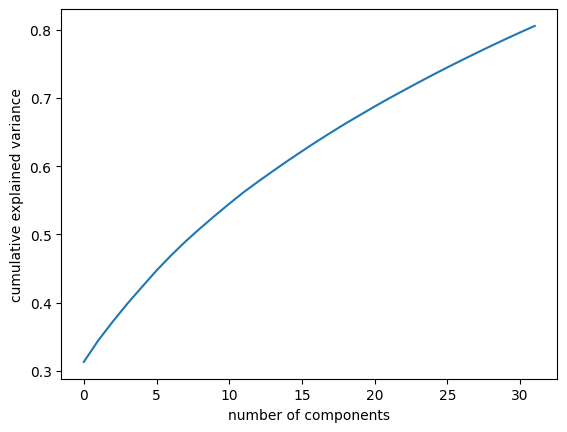

In [526]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [527]:
pca_df = pd.concat([princ_df, nodes[['semantic']]], axis=1)
pca_df

,principal component 1,principal component 2,semantic
0,-0.613750,-0.736778,phenotype
1,-0.729245,-0.321646,phenotype
2,-0.392119,0.207257,gene
3,-0.195943,1.651197,variant
4,-0.237910,-0.894757,phenotype
...,...,...,...
10270,-0.054418,-0.189138,phenotype
10271,-0.444655,-0.652147,gene
10272,-0.412632,-0.360582,gene
10273,-1.168231,-0.282968,gene


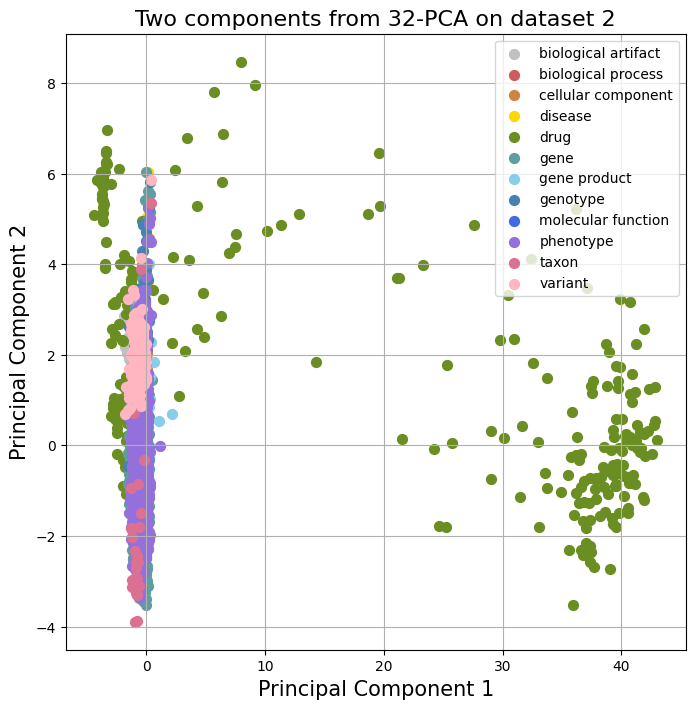

In [528]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two components from 32-PCA on dataset {dataset_nr}', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = pca_df['semantic'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

### t-SNE

In [529]:
X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(X_data)

In [530]:
comp_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
comp_tsne

,t-SNE 1,t-SNE 2
0,-22.588400,-5.342779
1,-52.648701,-11.907243
2,54.455029,35.815475
3,13.841108,31.183489
4,-19.908541,-20.814127
...,...,...
10270,-54.679256,47.035561
10271,-47.917263,31.298943
10272,34.635902,-17.824219
10273,24.019341,-4.194418


In [531]:
tsne_df = pd.concat([comp_tsne, nodes[['semantic']]], axis=1)
tsne_df

,t-SNE 1,t-SNE 2,semantic
0,-22.588400,-5.342779,phenotype
1,-52.648701,-11.907243,phenotype
2,54.455029,35.815475,gene
3,13.841108,31.183489,variant
4,-19.908541,-20.814127,phenotype
...,...,...,...
10270,-54.679256,47.035561,phenotype
10271,-47.917263,31.298943,gene
10272,34.635902,-17.824219,gene
10273,24.019341,-4.194418,gene


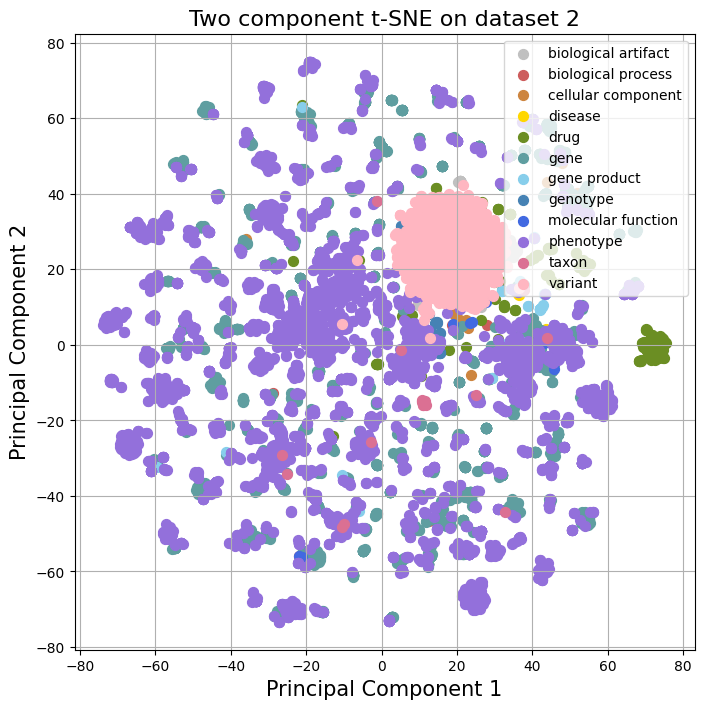

In [532]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two component t-SNE on dataset {dataset_nr}', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = tsne_df['semantic'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'], tsne_df.loc[indicesToKeep, 't-SNE 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

## GNNExplainer

In [1]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

Explanations will be generated

In [24]:
e2v_embedding

,Node,Embedding
0,0,"[0.4429384, -0.64671946, -0.045503706, 0.04694..."
1,1,"[0.7495496, -0.5790302, 0.16192597, 0.03131027..."
2,2,"[-0.21050918, -0.28908953, 0.118277326, -0.162..."
3,3,"[0.2527442, -0.2967686, 0.29164207, 0.8072669,..."
4,4,"[0.41442072, 0.06997513, 0.4540072, -0.0370618..."
...,...,...
10270,10270,"[0.21862394, 0.11319974, 0.31551972, 0.1497048..."
10271,10271,"[0.8747792, -0.7461259, 0.22221777, -0.0425329..."
10272,10272,"[0.5863251, -0.8054981, 0.27565393, 0.516578, ..."
10273,10273,"[0.6474387, -0.38251266, 0.43746328, 0.3413055..."


In [25]:
edge2vec_df

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00003929,pat-2,5,1542,0
1,WormBase:WBGene00006787,unc-52,5,304,interacts with,WormBase:WBGene00006789,unc-54,5,6544,0
2,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSSSCG00000015555,LAMC1,5,9268,1
3,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ZFIN:ZDB-GENE-021226-3,lamc1,5,5387,1
4,WormBase:WBGene00006787,unc-52,5,304,in orthology relationship with,ENSEMBL:ENSOANG00000001050,ENSEMBL:ENSOANG00000001050,5,2204,1
...,...,...,...,...,...,...,...,...,...,...
85987,458,scopolamine butylbromide,4,5945,targets,P11229,Muscarinic acetylcholine receptor M1,6,5919,17
85988,OMIM:300377.0080,"DMD, IVS62, A-G, -285",11,1578,is allele of,HGNC:2928,DMD,5,3310,15
85989,5297,dacomitinib,4,8798,targets,P12931,Proto-oncogene tyrosine-protein kinase Src,6,2379,17
85990,ClinVarVariant:981988,NC_000023.11:g.(31875374_31929595)_(31968515_3...,11,8189,has affected feature,HGNC:2928,DMD,5,3310,11


In [26]:
G = nx.DiGraph() # TODO: changed from Graph

for ind, node in e2v_embedding.iterrows():
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edge2vec_df.iterrows(): 
  G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.4429, -0.6467, -0.0455,  0.0469,  0.3007, -0.4822,  0.2423,  0.0707,
        -0.5349,  0.4175,  0.7552,  0.0628, -0.3813, -0.3389,  0.5671,  0.4919,
         0.0854,  0.0053, -0.2314,  0.8349,  0.5443,  0.7359, -0.1399, -0.2049,
        -0.1793,  0.0314, -0.7152,  0.1764,  0.3586, -0.4770,  0.0838, -0.3013,
         0.1751, -0.7785, -0.1280,  0.4082,  0.5959,  0.4058,  0.5182,  0.5561,
         0.3995, -0.1704,  0.3317, -0.1183, -0.1047,  0.2789,  0.3293, -0.1368,
         0.1259,  0.1704,  0.7724,  0.4460,  0.6070, -0.3315,  0.5776,  0.4367,
         0.2875, -0.7309,  0.2535,  0.5972,  0.4410, -0.4248, -0.3355,  0.3258])})
(2, 7693, {'edge_label': 'found in'})
Number of edges is 85878
Number of nodes is 10275


Obtain the embedding features per node.

In [27]:
x = torch.Tensor(e2v_embedding['Embedding'])
print(x.shape)

torch.Size([10275, 64])


Obtain the indices of the head and tail nodes per edge.

In [28]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)
print(edge_index.type())

torch.Size([2, 85878])
torch.LongTensor


In [29]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(2, 7693): 'found in',
 (2, 6542): 'enables',
 (2, 4877): 'causes condition',
 (2, 803): 'interacts with',
 (2, 649): 'is part of',
 (2, 4268): 'is part of',
 (2, 4344): 'in orthology relationship with',
 (2, 1195): 'causes condition',
 (2, 7451): 'causes condition',
 (2, 9992): 'causes condition',
 (2, 2800): 'causes condition',
 (2, 2986): 'causes condition',
 (2, 8340): 'interacts with',
 (2, 7355): 'causes condition',
 (2, 7000): 'causes condition',
 (2, 1351): 'causes condition',
 (2, 9823): 'in orthology relationship with',
 (2, 2526): 'in orthology relationship with',
 (2, 3579): 'interacts with',
 (2, 6934): 'in orthology relationship with',
 (2, 5868): 'in orthology relationship with',
 (2, 2321): 'interacts with',
 (2, 10173): 'causes condition',
 (2, 599): 'interacts with',
 (2, 833): 'is part of',
 (2, 898): 'causes condition',
 (2, 8292): 'causes condition',
 (2, 8708): 'in orthology relationship with',
 (2, 8332): 'causes condition',
 (2, 5684): 'causes condition',
 (2, 

In [30]:
def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model, epochs=700, num_hops=2, lr=0.01)

    trigger = False
    early_stop = 0
    size = 100   # change size of the explanation graph
    iterations = 10 # number of times GNNExplainer is executed

    while not trigger:
        node_feat_mask, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2, x=x, edge_index=edge_index, G=G)

        G2 = copy.deepcopy(G)
        
        if size is not None: 
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution limit is', limit)
        else: 
            limit = 0.5

        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])

        trigger = nx.has_path(G2, node_idx1, node_idx2)
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            
            plt.figure(figsize=(10, 10))
            ax, G_sub = visualize_subgraph([node_idx1, node_idx2], 
                                           edge_index, edge_mask, nodes=nodes, y=torch.Tensor(nodes.semantic_id), 
                                           seed = 667, num_hops = 2, threshold=limit, node_label = 'label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
            plt.show()
            
            return True
        
    return False

Obtain the indices of the nodes of interest.

In [46]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptom_drugs_df.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        explained1 = explain_edge(node_idx1, node_idx2)
        explained2 = explain_edge(node_idx2, node_idx1)

        if explained1 or explained2:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id})
            
print(found_explanation)

node1:
              id   semantic                          label  semantic_id
5727  HP:0003707  phenotype  Calf muscle pseudohypertrophy            9
node2:
        id semantic        label  semantic_id
9663  2774     drug  tropicamide            4
Edge Index Subgraph with 2 hops:
Nodes with features: torch.Size([1713, 64])
Edges: torch.Size([2, 8156])
Mapping: torch.Size([2]) tensor([ 953, 1624])
Hard Edge Mask: torch.Size([85878]) tensor([False, False, False,  ..., False, False, False])
Prediction: tensor([2.7319], requires_grad=True)


Explain edge between nodes 5727 and 9663:   8%|▊         | 56/700 [00:01<00:15, 40.41it/s]

KeyboardInterrupt: 

Explain edge between nodes 5727 and 9663:   8%|▊         | 56/700 [00:19<00:15, 40.41it/s]